In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import json
import torch.optim as optim

/home/rraju2/anaconda3/envs/mixer_cifar10/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from types import SimpleNamespace
from copy import deepcopy
from utils.dataloader import get_dataloaders
from utils.mlp_mixer import MaskedMLPMixer, create_binary_mask
from utils.utils import project_bin_mask, rand_bbox

In [3]:
%matplotlib inline

In [21]:
args = SimpleNamespace()
args.dataset = 'c10'
args.model = 'mlp_mixer'
args.batch_size = 128
args.eval_batch_size = 128
args.num_workers = 4
args.seed = 3407
args.epochs = 300
args.patch_size = 16
args.autoaugment = True
args.use_cuda = True
args.size = 224
args.split = 'index'
args.hidden_size = 128
args.hidden_c = 512
args.hidden_s = 64
args.num_layers = 8
args.num_classes = 10
args.drop_p = 0
args.off_act = False
args.is_cls_token = False
args.lambda_drop = 0.3
args.cutmix_beta = 1.0
args.cutmix_prob = 0.5
args.label_smoothing = 0.1
args.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [22]:
train_dataloader, test_dataloader = get_dataloaders(args)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
img, label, idx = next(iter(train_dataloader))

In [7]:
grid_img = torchvision.utils.make_grid(img, nrow=10).permute(1,2,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


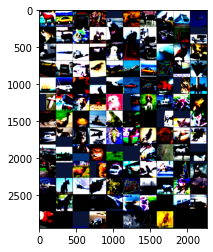

In [8]:
plt.imshow(grid_img)

In [23]:
model = MaskedMLPMixer(
            in_channels=3,
            img_size=args.size,
            hidden_size=args.hidden_size,
            patch_size = args.patch_size,
            hidden_c = args.hidden_c,
            hidden_s = args.hidden_s,
            num_layers = args.num_layers,
            num_classes=args.num_classes,
            drop_p=args.drop_p,
            off_act=args.off_act,
            is_cls_token=args.is_cls_token
        ).cuda()

In [24]:
with open("utils/avg_attns_trainset.json") as json_file:
    data = json.load(json_file)

In [25]:
optimizer = optim.SGD(model.parameters(), lr=0.1)
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=args.label_smoothing).cuda()

In [26]:
def compute_cos(params, params2):
    num = 0
    denom1 = 0
    denom2 = 0
    for idx in range(len(params)):
        num += torch.dot(params[idx].flatten(), params2[idx].flatten()).item()
        denom1 += params[idx].square().sum()
        denom2 += params2[idx].square().sum()
    denom1 = denom1.sqrt().item()
    denom2 = denom2.sqrt().item()
    return num/(denom1 * denom2)
    

In [27]:
avg_list = []
avg_cutmix_list = []

In [28]:
for epoch in range(1,11):
    model.load_state_dict(torch.load(f'../epochs/mixer_masked_cifar10_0.0_epoch{epoch}.pth'))
    sim_list = []

    for img, label, idx in train_dataloader:
        projected_mask = project_bin_mask(img, idx, data, args.lambda_drop, args.patch_size, img.shape[1], args.hidden_size)
        projected_mask = create_binary_mask(projected_mask)

        img, label = img.cuda(), label.cuda()

        projected_mask_ones = torch.ones_like(model.patch_emb(img))
        projected_mask, projected_mask_ones = projected_mask.cuda(), projected_mask_ones.cuda()

        out, _ = model(img, projected_mask_ones)
        
        loss = loss_fn(out, label)
        loss.backward()
        parameters = deepcopy([p.grad.data.detach().cpu() for p in model.parameters() if p.grad is not None and p.requires_grad])
        optimizer.zero_grad()

        out_occ, _ = model(img, projected_mask)
        loss = loss_fn(out_occ, label)
        loss.backward()
        occ_parameters = deepcopy([p.grad.data.detach().cpu() for p in model.parameters() if p.grad is not None and p.requires_grad])
        
        optimizer.zero_grad()
        sim = compute_cos(parameters, occ_parameters)
        sim_list.append(sim)
    avg_sim = sum(sim_list)/len(sim_list)
    avg_list.append(avg_sim)
    # print(avg_list)

    sim_list_cutmix = []
    for img, label, idx in train_dataloader:
        projected_mask = project_bin_mask(img, idx, data, args.lambda_drop, args.patch_size, img.shape[1], args.hidden_size)
        projected_mask = create_binary_mask(projected_mask)

        img, label = img.cuda(), label.cuda()

        projected_mask_ones = torch.ones_like(model.patch_emb(img))
        projected_mask, projected_mask_ones = projected_mask.cuda(), projected_mask_ones.cuda()

        # implement cutmix here
        lam = np.random.beta(args.cutmix_beta, args.cutmix_beta)
        rand_index = torch.randperm(img.size(0)).to(args.device)
        target_a = label
        target_b = label[rand_index]
        bbx1, bby1, bbx2, bby2 = rand_bbox(img.size(), lam)
        img[:, :, bbx1:bbx2, bby1:bby2] = img[rand_index, :, bbx1:bbx2, bby1:bby2]
        # adjust lambda to exactly match pixel ratio
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img.size()[-1] * img.size()[-2]))
        # --------
        out, _ = model(img, projected_mask_ones)
        
        # loss = loss_fn(out, target_a) * lam + loss_fn(out, target_b) * (1. - lam)
        loss = loss_fn(out, label)
        loss.backward()
        parameters = deepcopy([p.grad.data.detach().cpu() for p in model.parameters() if p.grad is not None and p.requires_grad])
        optimizer.zero_grad()

        # get first set of samples
        out_occ, _ = model(img, projected_mask)
        loss = loss_fn(out_occ, label)
        loss.backward()
        occ_parameters = deepcopy([p.grad.data.detach().cpu() for p in model.parameters() if p.grad is not None and p.requires_grad])
        
        optimizer.zero_grad()
        sim = compute_cos(parameters, occ_parameters)
        sim_list_cutmix.append(sim)
    avg_sim_cutmix = sum(sim_list_cutmix)/len(sim_list_cutmix)
    avg_cutmix_list.append(avg_sim_cutmix)
    # print(avg_cutmix_list)

In [30]:
epochs = np.arange(1,11)

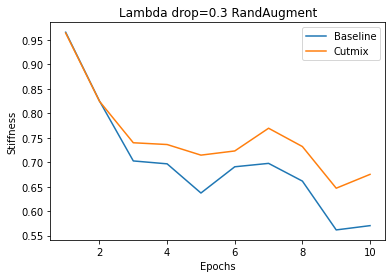

In [31]:
fig, ax = plt.subplots()
ax.plot(epochs, avg_list, label="Baseline")
ax.plot(epochs, avg_cutmix_list, label="Cutmix")
# ax.hist(sim_list, alpha=0.5, label="Baseline")
# ax.hist(sim_list_cutmix, alpha=0.5, label="Cutmix")
ax.set_xlabel('Epochs')
ax.set_ylabel('Stiffness')
ax.set_title('Lambda drop=0.3 RandAugment')
ax.legend()